# Projet SDATA

## Exercice 1

### Question 1: analyse des données 

La première étape est d'analyser les données contenues dans les fichiers ***spotify_dataset_train.csv*** et ***spotify_dataset_test.csv***. 
Avant de commencer, il nous faut formatter les données afin qu'elles soient numériques. Cela permettra ensuite d'utiliser certaines métriques comme les matrices de confusion par exemple.

Dans le code ci-dessous, nous chargeons donc les données d'entraînement et de test dans `dataset_train` et `dataset_test` respectivement.

Ensuite, le première variable à formatter est la variable ***explicit*** qui est, par défaut, représentée par des booléens. On transforme alors les booléens en 0 et 1 pour obtenir une valeur numérique.

La deuxième variable que nous devons modifier est la ***release_date***. Celle-ci est représentée par un `datetime` qui est un format de représentation des dates. Nous voulons obtenir un `timestamp` représentant la date sous la forme d'un nombre. 
Nous repérons plusieurs problèmes:
* Les données ne sont pas toutes au même format: par exemple: `2015-11-06` ou `1997`
* Certaines musiques sont sortis avant le 1er janvier 1970, référence du temps Unix

Pour résoudre ce problème, nous parcourons les ***release_dates***, on détecte le format, puis on le remplace par un `timestamp` en utilisant la time zone 'UTC' (Coordinated Universal Time) permettant d'éviter les soucis avant pour les dates avant 1970. Afin d'éviter les problèmes, nous affichons les valeurs que nous avons pas réussi à transformer correctement afin de pouvoir adapter le code si nécessaire.

Enfin, nous profitons de la boucle *for* pour remplacer le nom des genres en l'index associé dans la liste des genres, permettant ainsi d'obtenir un dataset complet ne contenant que des valeurs numériques.

In [23]:
import datetime

import numpy as np
import pandas

dataset_train = pandas.read_csv("dataset/spotify_dataset_train.csv")
dataset_test = pandas.read_csv("dataset/spotify_dataset_test.csv")

GENRE_MAP = ['blues', 'chanson', 'classical', 'country', 'dance', 'disco', 'edm', 'electro', 'folk', 'hip hop', 'jazz',
             'latin', 'metal', 'pop', 'punk', 'r&b', 'rap', 'reggae', 'rock', 'salsa', 'soul', 'techno']

dataset_train['explicit'] = dataset_train['explicit'].astype(np.int8)
dataset_test['explicit'] = dataset_test['explicit'].astype(np.int8)

for i, date in enumerate(dataset_train['release_date']):
    # Detect the date format and replace it with a utc timestamp for the train dataset
    if len(date.split('-')) == 3:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

    # Transform the genre string by the index equivalent
    dataset_train.loc[i, 'genre'] = GENRE_MAP.index(dataset_train.loc[i, 'genre'])

for i, date in enumerate(dataset_test['release_date']):
    # Detect the date format and replace it with a utc timestamp for the test dataset
    if len(date.split('-')) == 3:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

Il est maintenant temps de visualiser les données et de les comparer. 

La première chose que nous faisons est une matrice des corrélations, en utilisant `seaborn` et `matplotlib` pour les affichages.
On remarque grâce à cette matrice que peu de données sont réellement corrélées. Les seules choses que nous pouvons relever sont:
* ***loudness*** positivement corrélée avec ***energy***
* ***speechiness*** est positivement corrélée avec ***explicit***
* ***accousticness*** est négativement corrélée avec ***loudness*** et ***energy***

Ces corrélations sont tout à fait naturelles et semblent cohérentes avec le sujet. Par exemple, il n'est pas surprenant que les musiques contenant beaucoup de paroles aient une plus grande probabilité d'être explicites, ou encore il n'est pas surpenant que les musiques accoustiques soient peu énergiques.

La deuxième visualisation que nous faisons est un simple diagramme en barres des différentes classes représentées. Cela nous montre une chose intéressante: les différents genres ne contiennent pas du tout la même quantité de données, ce qui signifie, au vu des résultats, que les données choisies sont principalement basées sur la popularité des différents genres plutôt que dans l'objectif de faire un apprentissage équivalent sur chaque genre.

À l'aide de ces rapides analyses, nous supposons qu'il ne sera pas évident de prédire les classes car, premièrement, au vu de la matrice des corrélations, le genre n'est corrélé avec aucune autre variable, de plus, comme certains genres ne sont pas très présent, il y aura peu de données pour entraîner notre modèle.

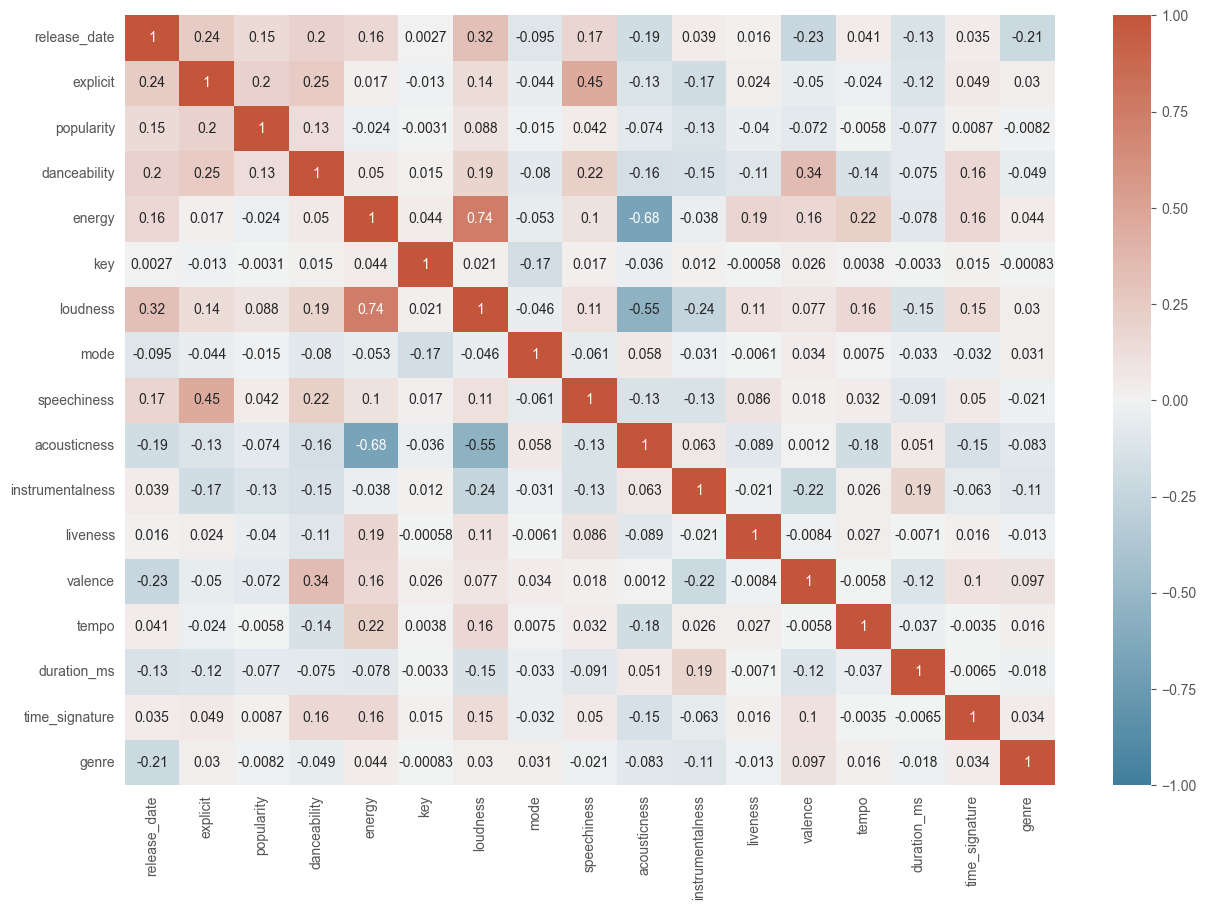

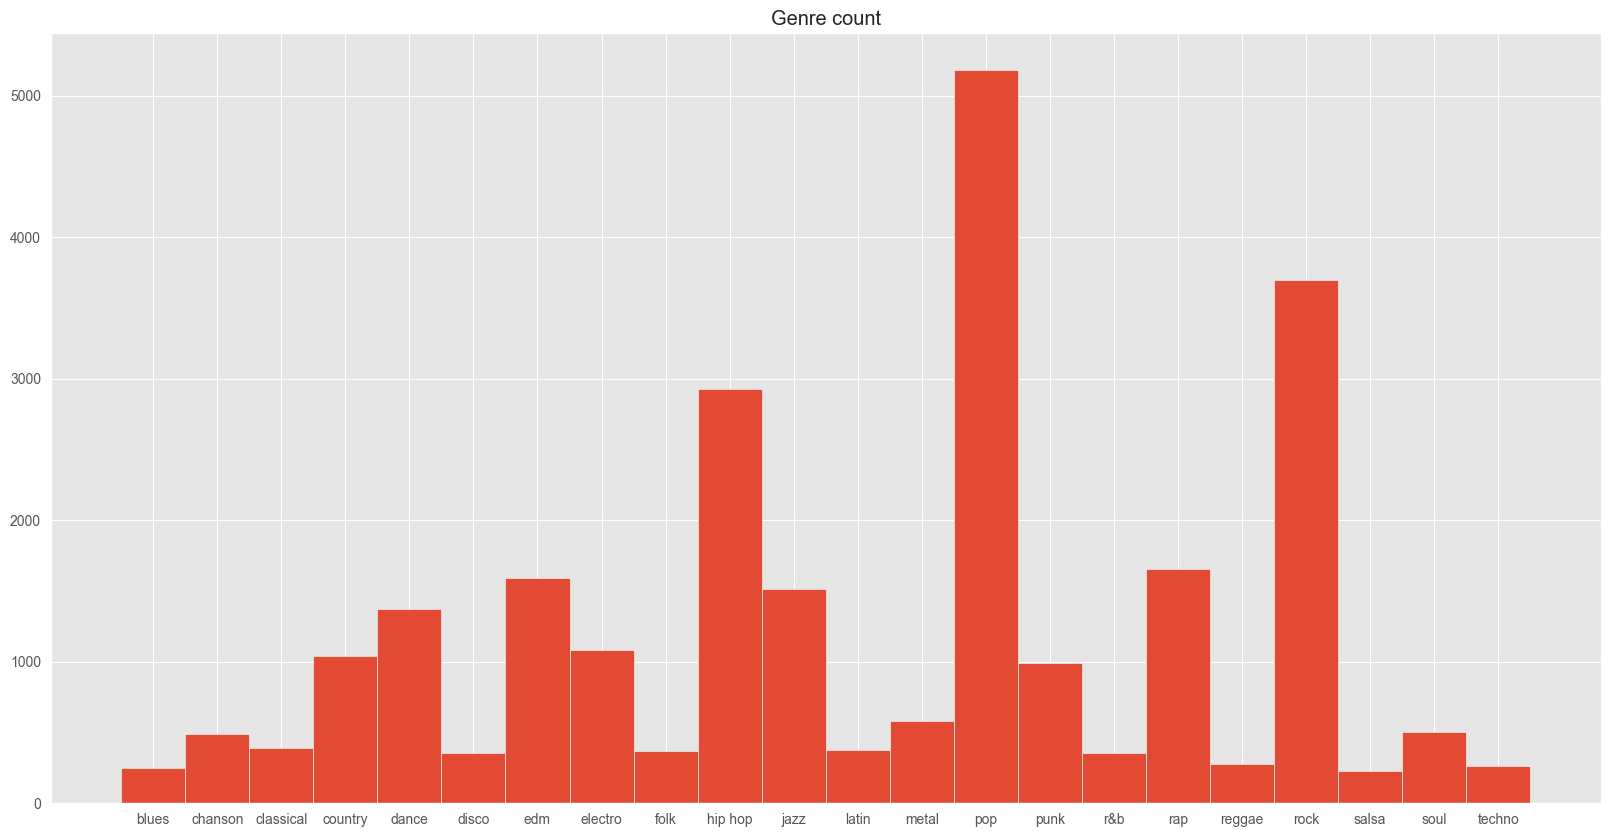

In [24]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
import seaborn

# Correlation
corr = dataset_train.corr()
plt.figure(figsize=(15, 10))
seaborn.heatmap(corr,
                cmap=seaborn.diverging_palette(230, 20, as_cmap=True),
                vmin=-1.0, vmax=1.0,
                square=False, annot=True)

# Genre count
plt.figure(figsize=(20, 10))
genre_counts = [np.count_nonzero(dataset_train['genre'] == x) for x in range(len(GENRE_MAP))]
plt.bar(GENRE_MAP, genre_counts, width=1, align='center')
plt.title('Genre count')

plt.show()

Nous décidons ensuite d'ajouter une couche d'analyse plus spécifique. Nous avons 2 types de variables: 
* Les variables allant d'un minimum à un maximum: exemple ***loudness***, plus elle est grande plus la musique est forte
* Les variables représentant une caractéristiques: exemple ***key*** représentant la note principale du morceau

Nous faisons donc une analyse pour ces deux catégories afin de découvrir quels genres se cachent derrière les différentes variables. 

Dans ce premier programme, nous gardons les paramètres du type min-max qui sont intéressants et comparons les moyennes sur chaque genre. La seule variable qui n'est pas du type min-max que nous utilisons malgré tout est la variable ***explicit***, cependant, contrainement à un paramètre comme ***mode*** qui vaut 0 pour majeur et 1 pour mineur, il est intéressant de faire une moyenne du paramètre ***explicit*** (valant 0 pour du contenu non explicite et 1 sinon) puisqu'il nous donnera un pourcentage de musiques contenant du contenu explicite au sein d'un genre.

Pour ce faire, nous utilisons `numpy.mean` qui permet de faire la moyenne sur chaque variable, le tout en construisant une sous-liste ne contenant que les données d'un genre donné à l'aide de `numpy.where`. Cela nous crée donc, pour chaque genre, une liste de taille *nombre_de_variables_intéressantes* contenant, pour chaque variable, la moyenne de cette variable sur ce genre. 

Grâce à cela, nous pouvons rentrer les moyennes sur chaque variable pour chaque genre dans un tableau puis simplement prendre le minimum et maximum pour chaque variable à l'aide de `numpy.min` et `numpy.max`.

Une fois encore, les résultats ci-dessous (voir la réponse du code) semblent cohérents. Par exemple nous apprenons que le genre le plus populaire est le r&b et le moins populaire est la salsa, ou encore le genre le moins acoustique est la techno et le plus acoustique est la musique classique.

In [25]:
# Keep only the interesting features to compare
interesting_features = np.array(
    ["explicit", "popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness",
     "valence", "tempo", "duration_ms"])
genres_compared = np.zeros(shape=(interesting_features.size, len(GENRE_MAP)))

# Fill the array column by column with the mean of each feature for each genre
for genre in range(genres_compared.shape[1]):
    # Returns an array containing the means for every feature
    genre_means = np.mean(dataset_train.iloc[np.where(dataset_train['genre'] == genre)], axis=0)
    for feature in range(genres_compared.shape[0]):
        genres_compared[feature][genre] = genre_means[interesting_features[feature]]

# Display the genre for the min and max value for each interesting feature
print(f"{'Feature':<20} {'Min':<15} {'Value':<15} {'Max':<15} {'Value':<15}")
for feature in range(genres_compared.shape[0]):
    # Find the index of the max and the min to get the genre associated
    min_genre = list(genres_compared[feature]).index(np.min(genres_compared[feature]))
    max_genre = list(genres_compared[feature]).index(np.max(genres_compared[feature]))

    print(f"{interesting_features[feature]:<20} ", end="")
    print(f"{GENRE_MAP[min_genre]:<15} ", end="")
    print(f"{round(genres_compared[feature][min_genre], 3):<15} ", end="")
    print(f"{GENRE_MAP[max_genre]:<15} ", end="")
    print(f"{round(genres_compared[feature][max_genre], 3):<15}")

Feature              Min             Value           Max             Value          
explicit             blues           0.0             hip hop         0.747          
popularity           salsa           8.978           r&b             41.849         
danceability         classical       0.308           reggae          0.763          
energy               classical       0.125           techno          0.866          
loudness             classical       -23.369         edm             -4.955         
speechiness          country         0.043           hip hop         0.23           
acousticness         techno          0.027           classical       0.925          
instrumentalness     country         0.01            classical       0.747          
valence              classical       0.194           salsa           0.859          
tempo                classical       102.124         techno          136.212        
duration_ms          punk            153819.613      techno      

Dans ce deuxième programme, nous regardons donc le deuxième type de variable et cherchons à trouver la valeur la plus et la moins populaire parmi tous les genres. Les deux variables intéressantes sont ***key*** et ***mode*** représentant respectivement la note principale du morceau, et le caractère majeur ou mineur de la tonalité.

De plus, avec ces deux paramètres, nous pouvons construire un dictionnaire des tonalités et trouver les tonalités les plus et moins populaires. L'intérêt de faire cela est que ce n'est pas parce que la note la plus populaire est le Ré et que le mode le plus populaire est le mineur que nécessairement la tonalité la plus populaire sera le Ré mineur !

Pour faire cela, nous contruisons trois dictionnaires contenant les différentes notes, modes et tonalités, en mettant leur compte à 0. Afin de construire la clé du dictionnaire des tonalités et faciliter les affichages, nous rajoutons également les équivalent en français des indices des dictionnaires des notes et des modes.
> Note au lecteur: certaines tonalités présentées ici n'existent pas en musique, comme par exemple le Sol# majeur, qui en réalité est du La*b* majeur. 
> Cependant, afin de faciliter la reconstitution des clés et la lecture du code, nous avons décider de n'utiliser que les dièses.

Ensuite, il suffit de parcourir les données et de compter les occurences de chaque clé, puis de trouver le maximum et minimum dans chaque dictionnaire afin de trouver les plus et moins populaires.

Nous avons donc les résultats suivant (voir la réponse du programme): le Sol est la note la plus populaire, le majeur est plus populaire que le mineur, et la tonalité la plus utilisée est le Do Majeur ! À l'inverse, la note la moins populaire est le Do# et la tonalité la moins utilisée est le Do# mineur.

In [26]:
# Definition of the different dictionnaries associated
keys = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
keys_equivalent = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

modes = {0: 0, 1: 0}
modes_equivalent = ["Minor", "Major"]

tonalities = {"C_Major": 0, 
              "C#_Major": 0, 
              "D_Major": 0, 
              "D#_Major": 0, 
              "E_Major": 0, 
              "F_Major": 0, 
              "F#_Major": 0, 
              "G_Major": 0, 
              "G#_Major": 0, 
              "A_Major": 0, 
              "A#_Major": 0, 
              "B_Major": 0, 
              "C_Minor": 0, 
              "C#_Minor": 0, 
              "D_Minor": 0, 
              "D#_Minor": 0, 
              "E_Minor": 0, 
              "F_Minor": 0, 
              "F#_Minor": 0, 
              "G_Minor": 0, 
              "G#_Minor": 0, 
              "A_Minor": 0, 
              "A#_Minor": 0, 
              "B_Minor": 0}

# Count the number each key, mode and tonality
for i in range(len(dataset_train["key"])):
    current_key = dataset_train["key"][i]
    current_mode = dataset_train["mode"][i]
    keys[current_key] += 1
    modes[current_mode] += 1
    tonalities[f"{keys_equivalent[current_key]}_{modes_equivalent[current_mode]}"] += 1
# Find the most used key, mode and tonality then display them
most_used_key = max(keys.values()) 
most_used_key_index = max(keys, key=keys.get)
most_used_mode = max(modes.values())
most_used_mode_index = max(modes, key=modes.get)
most_used_tonality = max(tonalities.values())  
most_used_tonality_name = max(tonalities, key=tonalities.get)

# Find the least used key, mode and tonality then display them
least_used_key = min(keys.values()) 
least_used_key_index = min(keys, key=keys.get)
least_used_mode = min(modes.values())
least_used_mode_index = min(modes, key=modes.get)
least_used_tonality = min(tonalities.values())  
least_used_tonality_name = min(tonalities, key=tonalities.get)

print(f"The most used key is {keys_equivalent[most_used_key_index]} with a number of {most_used_key} songs")
print(f"The most used mode is {modes_equivalent[most_used_mode_index]} with a number of {most_used_mode} songs")
print(f"The most used tonality is {most_used_tonality_name} with a number of {most_used_tonality} songs")
print("==========================================")
print(f"The least used key is {keys_equivalent[least_used_key_index]} with a number of {least_used_key} songs")
print(f"The least used mode is {modes_equivalent[least_used_mode_index]} with a number of {least_used_mode} songs")
print(f"The least used tonality is {least_used_tonality_name} with a number of {least_used_tonality} songs")

The most used key is G with a number of 2859 songs
The most used mode is Major with a number of 15750 songs
The most used tonality is C_Major with a number of 2128 songs
The least used key is D# with a number of 775 songs
The least used mode is Minor with a number of 9742 songs
The least used tonality is D#_Minor with a number of 280 songs


### Classification
#### Random Forest

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

X_train = dataset_train.iloc[:, dataset_train.columns != 'genre'].to_numpy()
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
Y_train = dataset_train.iloc[:, dataset_train.columns == 'genre'].to_numpy().flatten().astype(np.int8)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1)

rf = RandomForestClassifier(criterion='gini', max_features=0.5, class_weight='balanced')

#scores = cross_val_score(rf, X_train, Y_train, cv=2, scoring='f1_micro')
#print(scores)

rf.fit(X_train, Y_train)

y_pred = rf.predict(X_test)
print(f1_score(Y_test, y_pred, average='micro'))
#print(classification_report(Y_train, y_pred))

0.4588235294117647


In [28]:
test_pred = rf.predict(dataset_test.iloc[:].to_numpy())

for i in range(len(dataset_test)):
    dataset_test.loc[i, 'genre'] = GENRE_MAP[test_pred[i]]

dataset_test.to_csv('./dataset/spotify_dataset_test_pred.csv')

#### NNN

In [15]:
import torch


class NeuralNetwork(torch.nn.Module):
    def __init__(self, n1=20, n2=20, n3=20, n4=20, n5=20, p1=0, p2=0, p3=0, p4=0, p5=0):
        super().__init__()
        self.stack = torch.nn.Sequential(
            torch.nn.Linear(16, n1),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p1),

            torch.nn.Linear(n1, n2),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p2),

            torch.nn.Linear(n2, n3),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p3),

            torch.nn.Linear(n3, n4),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p4),

            torch.nn.Linear(n4, n5),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p5),

            torch.nn.Linear(n5, 22),
            #torch.nn.Sigmoid(),
        )
        #self.double()

    def forward(self, x):
        logits = self.stack(x)
        return logits


device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
#device = 'cpu'
print(f"Using {device} device")


Using cuda device


In [16]:
class MusicGenreClassifier(torch.nn.Module):
    def __init__(self, n1=20, n2=20, n3=20, n4=20, p1=0, p2=0, p3=0, p4=0):
        super(MusicGenreClassifier, self).__init__()

        # Feature extraction layers
        self.feature_layers = torch.nn.Sequential(
            torch.nn.Linear(16, n1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n1),
            torch.nn.Dropout(p=p1),

            torch.nn.Linear(n1, n2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n2),
            torch.nn.Dropout(p=p2),

            torch.nn.Linear(n2, n3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n3),
            torch.nn.Dropout(p=p3)
        )
        self.lstm_layers = torch.nn.LSTM(
            input_size=int(n3),
            hidden_size=int(n4),
            num_layers=2,
            batch_first=True,
            dropout=int(p4),
            bidirectional=True
        )

        # Classification layers
        self.classification_layers = torch.nn.Sequential(
            torch.nn.Linear(2 * n4, n4),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n4),
            torch.nn.Dropout(p=p4),

            torch.nn.Linear(n4, 22)
        )

    def forward(self, x):
        # Forward pass through feature extraction layers
        x = self.feature_layers(x)
        lstm_out, _ = self.lstm_layers(x)

        x = self.classification_layers(lstm_out)

        return x

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


def load_data_genre(batch_size=32):
    X = dataset_train.iloc[:, dataset_train.columns != 'genre'].to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = dataset_train.iloc[:, dataset_train.columns == 'genre'].to_numpy().flatten().astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=12345)

    TX_train = torch.tensor(X_train, dtype=torch.float).to(device)
    Ty_train = torch.tensor(y_train, dtype=torch.long).to(device)

    TX_test = torch.tensor(X_test, dtype=torch.float).to(device)
    Ty_test = torch.tensor(y_test, dtype=torch.long).to(device)

    t_dataset_train = TensorDataset(TX_train, Ty_train)
    t_dataset_test = TensorDataset(TX_test, Ty_test)

    train_batch = DataLoader(t_dataset_train, batch_size=batch_size, shuffle=True)
    validation_batch = DataLoader(t_dataset_test, batch_size=batch_size, shuffle=True)
    return train_batch, validation_batch

In [18]:
import ray
from ray.train import Checkpoint
import os
import tempfile
from tqdm.notebook import tqdm
from ray.air import session


def train_genre(config, MAX_EPOCH=1000, SHOW_BAR=True):
    running_losses = []
    validation_losses = []
    model = config['model'](n1=config['n1'], n2=config['n2'], n3=config['n3'], n4=config['n4'],
                            p1=config['p1'], p2=config['p2'], p3=config['p3'], p4=config['p4']).to(device)

    loss_fn = config['loss_fn']()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)

    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        model.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    train_batch, validation_batch = load_data_genre(batch_size=config['batch_size'])

    if SHOW_BAR:
        bar = tqdm(total=MAX_EPOCH)
        bar.update(start_epoch)
    for epoch in range(start_epoch, MAX_EPOCH):
        running_loss = 0.
        model.train()
        for i, data in enumerate(train_batch):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        validation_loss = 0.
        accuracy = 0
        validation_total = 0
        model.eval()
        for i, data in enumerate(validation_batch):
            with torch.no_grad():
                inputs, labels = data
                outputs = model(inputs).squeeze()
                loss = loss_fn(outputs, labels.squeeze())
                validation_loss += loss.item()
                validation_total += labels.size(0)
                accuracy += (torch.argmax(outputs, 1) == labels).sum().item()

        running_loss /= len(train_batch)
        validation_loss /= len(validation_batch)
        running_losses.append(running_loss)
        validation_losses.append(validation_loss)
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            ray.train.report(
                {"loss": validation_loss, "accuracy": accuracy / validation_total},
                checkpoint=checkpoint,
            )

        if SHOW_BAR:
            bar.update(1)
            bar.set_postfix(str=f"Running loss: {running_loss:.5f} - Validation loss: {validation_loss:.5f}.")
    if SHOW_BAR:
        bar.close()
    return running_losses, validation_losses, model


In [19]:
def test_accuracy(model):
    train_batch, validation_batch = load_data_genre(batch_size=32)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in validation_batch:
            inputs, labels = data
            outputs = model(inputs).squeeze()
            total += labels.size(0)
            correct += (torch.argmax(outputs, 1) == labels).sum().item()

    return correct / total

In [ ]:
from ray.tune import JupyterNotebookReporter
from functools import partial
from ray.tune.schedulers import ASHAScheduler
from ray import tune

config = {
    "n1": tune.choice(np.arange(1, 4096, 1)),
    "n2": tune.choice(np.arange(1, 4096, 1)),
    "n3": tune.choice(np.arange(1, 4096, 1)),
    "n4": tune.choice(np.arange(1, 4096, 1)),
    #"n5": tune.choice(np.arange(1, 1000, 1)),
    "p1": tune.choice(np.linspace(0, 1, 100)),
    "p2": tune.choice(np.linspace(0, 1, 100)),
    "p3": tune.choice(np.linspace(0, 1, 100)),
    "p4": tune.choice(np.linspace(0, 1, 100)),
    #"p5": tune.choice(np.linspace(0, 1, 50)),
    # "n2": tune.choice([1]),
    # "n3": tune.choice([1]),
    # "p1": tune.choice([1]),
    # "p2": tune.choice([1]),
    # "p3": tune.choice([1]),
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice([256, 512, 1024, 2048]),
    'model': NeuralNetwork,
    'loss_fn': torch.nn.CrossEntropyLoss,
    'loader': load_data_genre
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=200,
    grace_period=1,
    reduction_factor=2,
)
result = tune.run(
    partial(train_genre, SHOW_BAR=False),
    resources_per_trial={"cpu": 4, "gpu": 0},
    config=config,
    num_samples=1,
    scheduler=scheduler,
    progress_reporter=JupyterNotebookReporter()
)
best_trial = result.get_best_trial("accuracy", "max", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

2024-01-24 11:03:42,434	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-24 11:19:28,318	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


  0%|          | 0/150 [00:00<?, ?it/s]

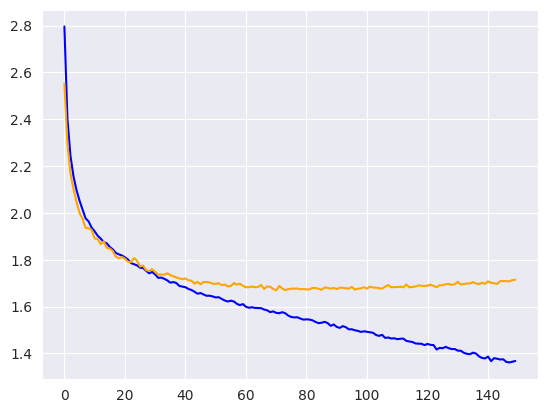

In [86]:
import matplotlib.pyplot as plt

config = {'n1': 2565, 'n2': 4046, 'n3': 1828, 'n4': 2648, 'p1': 0.5757575757575758, 'p2': 0.7676767676767677,
          'p3': 0.686868686868687, 'p4': 0.08080808080808081, 'lr': 0.00024444515305828874, 'batch_size': 1024,
          'model': NeuralNetwork, 'loss_fn': torch.nn.CrossEntropyLoss}
r_l, v_l, model = train_genre(config, MAX_EPOCH=150)
plt.plot(r_l, color='blue')
plt.plot(v_l, color='orange')

In [20]:
from sklearn.metrics import f1_score

train_batch, validation_batch = load_data_genre(batch_size=best_trial.config['batch_size'])

y_preds = []
y_true = []

for i, data in enumerate(validation_batch):
    inputs, labels = data
    outputs = torch.argmax(model(inputs).squeeze(), 1).cpu()
    #print(outputs)
    y_preds.extend(outputs)
    y_true.extend(labels.cpu())

print(f1_score(y_true, y_preds, average='micro'))

NameError: name 'best_trial' is not defined

### Exercice 2

In [ ]:
import datetime

import numpy as np
import pandas
import hashlib

dataset = pandas.read_csv("dataset/spotify_dataset_subset.csv")

GENRE_MAP = ['blues', 'chanson', 'classical', 'country', 'dance', 'disco', 'edm', 'electro', 'folk', 'hip hop', 'jazz',
             'latin', 'metal', 'pop', 'punk', 'r&b', 'rap', 'reggae', 'rock', 'salsa', 'soul', 'techno']

dataset['explicit'] = dataset['explicit'].astype(np.int8)

for i, date in enumerate(dataset['release_date']):
    # Detect the date format and replace it with a utc timestamp for the train dataset
    if len(date.split('-')) == 3:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)
    dataset.loc[i, 'artist_id'] = int.from_bytes(hashlib.sha256(dataset.loc[i, 'artist_name'].encode()).digest(), 'big')

print(dataset.columns)

In [ ]:
from sklearn.preprocessing import StandardScaler


def load_data_popularity(batch_size=32):
    X = dataset[dataset.columns.difference(['genres', 'id', 'track_name', 'artist_name', 'popularity'])].to_numpy()
    Y = dataset.loc[:, dataset.columns == 'popularity'].to_numpy().flatten().astype(np.float64)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12345)

    TX_train = torch.tensor(X_train, dtype=torch.float).to(device)
    Ty_train = torch.tensor(y_train, dtype=torch.float).to(device)

    TX_test = torch.tensor(X_test, dtype=torch.float).to(device)
    Ty_test = torch.tensor(y_test, dtype=torch.float).to(device)

    t_dataset_train = TensorDataset(TX_train, Ty_train)
    t_dataset_test = TensorDataset(TX_test, Ty_test)

    train_batch = DataLoader(t_dataset_train, batch_size=batch_size, shuffle=True)
    validation_batch = DataLoader(t_dataset_test, batch_size=batch_size, shuffle=True)
    return train_batch, validation_batch

In [ ]:
import torch


class PopularityNetwork(torch.nn.Module):
    def __init__(self, n1=20, n2=20, n3=20, n4=20, n5=20, p1=0, p2=0, p3=0, p4=0, p5=0):
        super().__init__()
        self.stack1 = torch.nn.Sequential(
            torch.nn.Linear(16, n1),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p1),

            torch.nn.Linear(n1, n2),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p2),

            torch.nn.Linear(n2, n3),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p3),

            torch.nn.Linear(n3, n4),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p4),
        )
        self.residuals = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(16, n4),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.5)
            ) for _ in range(5)
        ])
        self.stack2 = torch.nn.Sequential(
            torch.nn.Linear(n4, n5),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p5),
        )
        self.prediction = torch.nn.Sequential(
            torch.nn.Linear(n5, 1),
        )

    def forward(self, x):
        logits = self.stack1(x)
        for i, residual in enumerate(self.residuals):
            logits += residual(x)
        logits = self.stack2(logits)
        result = self.prediction(logits)
        return result


device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
#device = 'cpu'
print(f"Using {device} device")


In [21]:
import ray
from ray.train import Checkpoint
import os
import tempfile
from tqdm.notebook import tqdm
from ray.air import session

def train_popularity(config, MAX_EPOCH=1000, SHOW_BAR=True):
    running_losses = []
    validation_losses = []
    model = config['model'](n1=config['n1'], n2=config['n2'], n3=config['n3'], n4=config['n4'],
                            p1=config['p1'], p2=config['p2'], p3=config['p3'], p4=config['p4']).to(device)

    loss_fn = config['loss_fn']()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)

    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        model.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    train_batch, validation_batch = load_data_popularity(batch_size=config['batch_size'])

    if SHOW_BAR:
        bar = tqdm(total=MAX_EPOCH)
        bar.update(start_epoch)
    for epoch in range(start_epoch, MAX_EPOCH):
        running_loss = 0.
        model.train()
        for i, data in enumerate(train_batch):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs).squeeze()
            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        validation_loss = 0.
        accuracy = 0
        validation_total = 0
        model.eval()
        for i, data in enumerate(validation_batch):
            with torch.no_grad():
                inputs, labels = data
                outputs = model(inputs).squeeze()
                loss = loss_fn(outputs, labels.squeeze())
                validation_loss += loss.item()
                validation_total += labels.size(0)
                accuracy += (outputs == labels).sum().item()

        running_loss /= len(train_batch)
        validation_loss /= len(validation_batch)
        running_losses.append(running_loss)
        validation_losses.append(validation_loss)
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            ray.train.report(
                {"loss": validation_loss, "accuracy": accuracy / validation_total},
                checkpoint=checkpoint,
            )

        if SHOW_BAR:
            bar.update(1)
            bar.set_postfix(str=f"Running loss: {running_loss:.5f} - Validation loss: {validation_loss:.5f}.")
    if SHOW_BAR:
        bar.close()
    return running_losses, validation_losses, model


In [22]:
from ray.tune import JupyterNotebookReporter
from functools import partial
from ray.tune.schedulers import ASHAScheduler
from ray import tune

config = {
    "n1": tune.choice(np.arange(1, 512, 1)),
    "n2": tune.choice(np.arange(1, 512, 1)),
    "n3": tune.choice(np.arange(1, 512, 1)),
    "n4": tune.choice(np.arange(1, 512, 1)),
    "p1": tune.choice(np.linspace(0, 1, 20)),
    "p2": tune.choice(np.linspace(0, 1, 20)),
    "p3": tune.choice(np.linspace(0, 1, 20)),
    "p4": tune.choice(np.linspace(0, 1, 20)),
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice([256, 512]),
    'model': PopularityNetwork,
    'loss_fn': torch.nn.MSELoss,
    'loader': load_data_popularity
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=50,
    grace_period=1,
    reduction_factor=2,
)
result = tune.run(
    partial(train_popularity, SHOW_BAR=False),
    resources_per_trial={"cpu": 4, "gpu": 0},
    config=config,
    num_samples=1,
    scheduler=scheduler,
    progress_reporter=JupyterNotebookReporter()
)
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

2024-01-25 10:53:24,860	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-25 10:53:32,352	ERROR tune_controller.py:1374 -- Trial task failed for trial train_popularity_94e1c_00000
Traceback (most recent call last):
  File "D:\Development\Python\projet_sdata\venv\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "D:\Development\Python\projet_sdata\venv\lib\site-packages\ray\_private\auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "D:\Development\Python\projet_sdata\venv\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "D:\Development\Python\projet_sdata\venv\lib\site-packages\ray\_private\worker.py", line 2624, in get
    raise

Trial name
train_popularity_94e1c_00000


TuneError: ('Trials did not complete', [train_popularity_94e1c_00000])

In [ ]:
import matplotlib.pyplot as plt

config = {'n1': 50, 'n2': 40, 'n3': 50, 'n4': 20, 'p1': 0.5, 'p2': 0.5,
          'p3': 0.5, 'p4': 0.2, 'lr': 0.0001, 'batch_size': 256,
          'model': PopularityNetwork, 'loss_fn': torch.nn.MSELoss}
r_l, v_l, model = train_popularity(best_trial.config, MAX_EPOCH=250)
plt.plot(r_l, color='blue')
plt.plot(v_l, color='orange')

In [ ]:
from sklearn.metrics import f1_score

train_batch, validation_batch = load_data_popularity(batch_size=config['batch_size'])

y_preds = []
y_true = []

for i, data in enumerate(validation_batch):
    inputs, labels = data
    outputs = model(inputs).cpu().detach().numpy()
    #print(outputs)
    y_preds.extend(outputs)
    y_true.extend(labels.cpu().detach().numpy())

print(f1_score(y_true, y_preds, average='micro'))

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import svm

svc = svm.SVR()

X = dataset[dataset.columns.difference(['genres', 'id', 'track_name', 'artist_name', 'popularity'])].to_numpy()
Y = dataset.loc[:, dataset.columns == 'popularity'].to_numpy().flatten().astype(np.float64)
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12345)

svc.fit(X_train, y_train)

print(mean_squared_error(y_test, svc.predict(X_test)))